## インポート

In [2]:
# パッケージの読み込み
import pandas as pd
import numpy as np
import datetime as dt
import time
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', 500)

# 前処理

**class: TypeChecker()**: 型をチェックするクラス\
**is_numeric(column)**: そのカラムのdtypeが数字型であるかどうか\
**is_boolean(column)**: そのカラムのdtypeがブール型であるかどうか\
**is_string(column)**: そのカラムのdtypeが文字列型であるかどうか

In [3]:
# dependency
# -pandas
class TypeChecker():
  def __init__(self):
    self.numeric_columns = ["int8","int16","int32","int64","uint8","uint16","uint32","uint64","float8","float16","float32","float64", "int", "uint", "float"]
    self.boolean_columns = ["bool"]
    self.string_columns = ["object", "str"]
    self.date_columns = ["datetime64[ns]"]
  def is_numeric(self, column):
    return column in self.numeric_columns
  def is_boolean(self, column):
    return column in self.boolean_columns
  def is_string(self, column):
    return column in self.date_columns

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
df["a"] = "a"

tc = TypeChecker()
tc.is_string(df["a"].dtype)
tc.is_boolean(df["holiday"].dtype)

True

## 欠損値処理

**class: PreprocessForNull()**: null値に対しての処理をするクラス\
**drop_na_index(columns)**: columnsに対してnan値があった場合、その行を消去する\
**drop_na_index_all()**: nan値がある行を消去する\
**drop_na_column_all()**: nan値がある列を消去する\
**fill_na_by_value(columns, value)**: 任意のcolumnsに対してnan値を任意の値valueで補完する\
**fill_na_by_mean(columns, value)**: 任意のcolumnsに対してnan値を平均値で補完する\
**fill_na_by_mode(columns, value)**: 任意のcolumnsに対してnan値を最頻値で補完する\
**get_df(columns, value)**: 処理を終えたdfを取得する

In [5]:
# dependency
# -pandas
class PreprocessForNull():
  def __init__(self, df):
    self.df = df
  def info(self):
    print(self.df.isnull().sum())
  # nanを持つindexを消去
  def drop_na_index(self, columns):
    self.df = self.df.dropna(subset=columns)
  def drop_na_index_all(self):
    self.df = self.df.dropna()
  def drop_na_column_all(self):
    self.df = self.df.dropna(axis=1)
  def fill_na_by_value(self, columns, value=0):
    self.df[columns] = self.df[columns].fillna(value)
  def fill_na_by_mean(self, columns):
    self.df[columns] = self.df[columns].fillna(self.df[columns].mean())
  def fill_na_by_mode(self, columns):
    self.df[columns] = self.df[columns].fillna(self.df[columns].mode().iloc[0])
  def fill_na_by_arbitary_func(self, columns, func):
    self.df[columns] = self.df[columns].fillna(method = func)
  def get_df(self):
    return self.df

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
df["a"] = np.nan
df['a'].iloc[0] = 3
df['a'].iloc[1] = 4
df['a'].iloc[2] = 4
pfn = PreprocessForNull(df)
pfn.fill_na_by_mean(["a"])
df = pfn.get_df()
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,num_rides,holiday,Max_Temp,Min_Temp,Rain_in,Snow&Hail_in,obs_time_ Snow&Hail_in,a
date,,,,,,,,
2017-01-01,281263.0,False,48,40,0.001,0.000,0.0,3.000000
2017-01-02,224893.0,True,41,37,0.210,0.001,0.0,4.000000
2017-01-03,278099.0,False,43,39,0.580,0.000,0.0,4.000000
2017-01-04,289301.0,False,52,34,0.000,0.000,0.0,3.666667
2017-01-05,324421.0,False,34,27,0.000,0.000,0.0,3.666667


##訓練データ・テストデータ分割

In [54]:
# dependency
# - sklearn.model_selection.train_test_split
# -pandas

class DataSplit():
  def __init__(self, df):
    self.df = df
    self.X = None
    self.y = None

  def __preprocess_for_null(self):
    type_checker = TypeChecker()
    pfn = PreprocessForNull()
    for column in list(self.df.columns):
      dtype = self.train_x[column].dtype
      if type_checker.is_numeric(dtype): pfn.fill_na_by_mean(column)
      if type_checker.is_boolean(dtype): pfn.drop_na_index([column])
      if type_checker.is_string(dtype): pfn.drop_na_index(column)

  def __sort_by_index(self, train_x, test_x, train_y, test_y):
    train_x = train_x.sort_index()
    test_x = test_x.sort_index()
    train_y = train_y.sort_index()
    test_y = test_y.sort_index()
    return train_x, test_x, train_y, test_y

  def set_propose_column(self, column):
    self.df.dropna(subset=[column])
    self.X = self.df.drop(columns=column)
    self.y = self.df[column]

  def hold_out(self, seed=0, preprocess_for_null=False, sort_by_index=False):
    if preprocess_for_null == True: self.__preprocess_for_null()
    train_x, test_x, train_y, test_y = train_test_split(self.X, self.y, train_size = 0.8 ,test_size = 0.2, shuffle = True, random_state = seed)
    if sort_by_index == True:
      train_x, test_x, train_y, test_y = self.__sort_by_index(train_x, test_x, train_y, test_y)
    return train_x, test_x, train_y, test_y

  def k_fold_cross_validation(self, n_splits, shuffle=True, seed=0, preprocess_for_null=False, sort_by_index=False):
    if preprocess_for_null == True: self.__preprocess_for_null()
    res = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    for train, test in kf.split(self.X, self.y):
      train_x = self.X.iloc[train]
      train_y = self.y.iloc[train]
      test_x = self.X.iloc[test]
      test_y = self.y.iloc[test]
      if sort_by_index == True:
        train_x, test_x, train_y, test_y = self.__sort_by_index(train_x, test_x, train_y, test_y)
      res.append((train_x, train_y, test_x, test_y))
    return res

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
y = df["num_rides"]
X = df.drop(columns="num_rides")
ds = DataSplit(df)
ds.set_propose_column("num_rides")
# dat = ds.k_fold_cross_validation(n_splits=4)
train_x, test_x, train_y, test_y = ds.hold_out(seed=0, sort_by_index=True)
train_x.sort_values("date")

,holiday,Max_Temp,Min_Temp,Rain_in,Snow&Hail_in,obs_time_ Snow&Hail_in
date,,,,,,
2017-01-01,False,48,40,0.001,0.000,0.000
2017-01-04,False,52,34,0.000,0.000,0.000
2017-01-05,False,34,27,0.000,0.000,0.000
2017-01-07,False,26,20,0.320,5.100,0.001
2017-01-08,False,25,16,0.000,0.000,3.900
...,...,...,...,...,...,...
2019-12-25,True,47,32,0.000,0.000,0.000
2019-12-27,False,54,46,0.000,0.000,0.000
2019-12-28,False,51,43,0.000,0.000,0.000


##エンコーディング


**one_hot_encoding_by_target_column(df, category_column)** : df 内の任意の category_column を OneHotEncoder で dummy変数にして、そのdata frameおよび新たな column を返す

In [37]:
# dependency
# - pandas
# - sklearn.preprocessing.OneHotEncoder
class OneHotEncoding():
  def __init__(self, train_x, test_x, columns):
    self.train_x = train_x
    self.test_x = test_x
    self.ohe = OneHotEncoder(sparse=False, categories='auto')
    self.columns = columns

  def __fit_transform_and_get_new_df(self, drop):
    new_columns = []
    for i, col in enumerate(self.columns):
      new_columns += [f'{col}_{v}' for v in self.ohe.categories_[i]]
    ndf_train = pd.DataFrame(self.ohe.transform(self.train_x[self.columns]), columns=new_columns, index=self.train_x.index)
    ndf_train = pd.concat([self.train_x, ndf_train], axis=1)
    ndf_test = pd.DataFrame(self.ohe.transform(self.test_x[self.columns]), columns=new_columns, index=self.test_x.index)
    ndf_test = pd.concat([self.test_x, ndf_test], axis=1)
    if drop == True: 
      ndf_train.drop(columns=self.columns, inplace=True)
      ndf_test.drop(columns=self.columns, inplace=True)
    self.train_x = ndf_train
    self.test_x = ndf_test

  def fit(self):
    self.ohe.fit(self.train_x[self.columns])

  def transform(self):
    return self.ohe.transform(self.train_x[self.columns]), self.ohe.transform(self.test_x[self.columns])

  def fit_transform_and_get_new_df(self, drop=True):
    self.ohe.fit(self.train_x[self.columns])
    self.__fit_transform_and_get_new_df(drop)
    return self.train_x, self.test_x

  def transform_and_get_new_df(self, drop=True):
    self.__fit_trainsform_and_get_new_df(drop)
    return self.train_x, self.test_x

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
df["d"] = "s"
df["d"].iloc[0]="a"
df["e"] = "s"
df["f"] = "s"
ds = DataSplit(df)
ds.set_propose_column("num_rides")
train_x, test_x, train_y, train_y = ds.hold_out(seed=0)
ohefd = OneHotEncoding(train_x, test_x, ["d", "e", "f", "holiday"])
train_x, test_x = ohefd.fit_transform_and_get_new_df(drop=False)
train_x.sort_values("date")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,holiday,Max_Temp,Min_Temp,Rain_in,Snow&Hail_in,obs_time_ Snow&Hail_in,d,e,f,d_a,d_s,e_s,f_s,holiday_False,holiday_True
date,,,,,,,,,,,,,,,
2017-01-01,False,48,40,0.001,0.000,0.000,a,s,s,1.0,0.0,1.0,1.0,1.0,0.0
2017-01-04,False,52,34,0.000,0.000,0.000,s,s,s,0.0,1.0,1.0,1.0,1.0,0.0
2017-01-05,False,34,27,0.000,0.000,0.000,s,s,s,0.0,1.0,1.0,1.0,1.0,0.0
2017-01-07,False,26,20,0.320,5.100,0.001,s,s,s,0.0,1.0,1.0,1.0,1.0,0.0
2017-01-08,False,25,16,0.000,0.000,3.900,s,s,s,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,True,47,32,0.000,0.000,0.000,s,s,s,0.0,1.0,1.0,1.0,0.0,1.0
2019-12-27,False,54,46,0.000,0.000,0.000,s,s,s,0.0,1.0,1.0,1.0,1.0,0.0
2019-12-28,False,51,43,0.000,0.000,0.000,s,s,s,0.0,1.0,1.0,1.0,1.0,0.0


##次元削減

**class: PrincipalComponentAnalysis** 

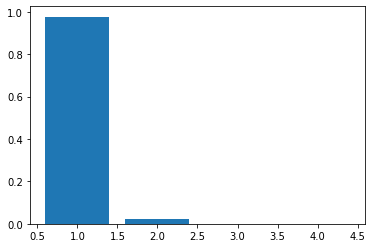

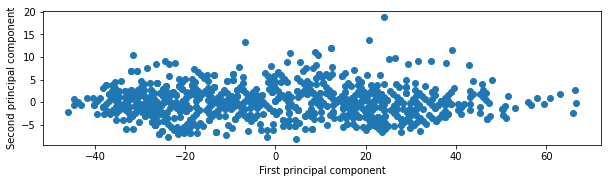

In [41]:
# dependency
# - pandas
# - OneHotEncoding <- 自作
# - TypeChecker <- 自作
# - sklearn.decomposition.PCA
# - sklearn.preprocessing.SandardScaler
# - matplotlib.pyplot

class PrincipalComponentAnalysis():
  def __init__(self, train_x, test_x, column_number):
    self.train_x = train_x
    self.test_x = test_x
    self.column_number = column_number
    self.pca = PCA(n_components=column_number)

  def __one_hot_encoding(self):
    type_checker = TypeChecker()
    category_columns = []
    for column in list(self.train_x.columns):
      dtype = self.train_x[column].dtype
      if type_checker.is_boolean(dtype): category_columns.append(column)
      if type_checker.is_string(dtype): category_columns.append(column)
    ohe = OneHotEncoding(self.train_x, self.test_x, category_columns)
    self.train_x, self.test_x = ohe.fit_transform_and_get_new_df()

  def fit(self, one_hot_encoding=False):
    if one_hot_encoding == True: self.__one_hot_encoding()
    self.pca.fit(self.train_x)

  def transform(self):
    self.train_x, self.test_x = self.pca.transform(self.train_x), self.pca.transform(self.test_x)
    return self.train_x, self.test_x

  def fit_transform(self, one_hot_encoding=False):
    if one_hot_encoding == True: self.__one_hot_encoding()
    self.pca.fit(self.train_x)
    self.train_x, self.test_x = self.pca.transform(self.train_x), self.pca.transform(self.test_x)
    return self.train_x, self.test_x

  # fitしている必要がある
  def show_bar(self):
    plt.bar([n for n in range(1, len(self.pca.explained_variance_ratio_)+1)], self.pca.explained_variance_ratio_)

  def two_dimentional_plot(self):
    plt.figure(figsize=(10,10))
    train_x_pca, test_x_pca = self.transform()
    plt.scatter(train_x_pca[:,0], train_x_pca[:, 1])
    plt.gca().set_aspect('equal')
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
ds = DataSplit(df)
ds.set_propose_column("num_rides")
train_x, test_x, train_y, train_y = ds.hold_out(seed=0)
pca = PrincipalComponentAnalysis(train_x, test_x, 4)
pca.fit(one_hot_encoding=True)
pca.show_bar()
pca.two_dimentional_plot()
# print(df)

##変換(標準化, 対数変換, Box-Cox変換, Yeo-Johnson変換)

**get_scaled_by_column(df, target_columns, scaler=StandardScaler(), inplace=False, fit=True, transform=True):** : df 内の任意の column を scaler によってスケーリングする

In [64]:
# dependency
# - pandas
# - sklearn.preprocessing.<xxxx> (ex: StandardScaler)

class Transformer():
  def __init__(self, train, test):
    self.train = train
    self.test = test
    self.standard_scaler = StandardScaler()

  def logarithmic_transformation(self, columns, log_type=1):
    assert log_type in [1, 2, 3], '"log_type" must be 1 or 2 or 3'
    func = lambda x: np.log(x)
    if log_type == 2: func = lambda x: np.log1p(x)
    if log_type == 3: func = lambda x: np.sign(x) * np.log(np.abs(x))
    self.train[columns], self.test[columns] = self.train[columns].apply(func), self.test[columns].apply(func)
    return self.train, self.test

  def standardization_fit(self, columns):
    self.standard_scaler.fit(self.train[columns])

  def standardization_transform(self, columns):
    self.train[columns], self.test[columns] = self.standard_scaler.transform(self.train[columns]), self.standard_scaler.transform(self.test[columns])
    return self.train, self.test

  def standardization_fit_transform(self, columns):
    self.standard_scaler.fit(self.train[columns])
    self.train[columns], self.test[columns] = self.standard_scaler.transform(self.train[columns]), self.standard_scaler.transform(self.test[columns])
    return self.train, self.test

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
ds = DataSplit(df)
ds.set_propose_column("num_rides")
train_x, test_x, train_y, train_y = ds.hold_out(seed=0, sort_by_index=True)
ts = Transformer(train_x, test_x)
train_x, test_x = ts.logarithmic_transformation(columns=["Max_Temp", "Min_Temp"], log_type=2)
train_x, test_x = ts.standardization_fit_transform(columns=["Max_Temp", "Min_Temp"])
train_x

,holiday,Max_Temp,Min_Temp,Rain_in,Snow&Hail_in,obs_time_ Snow&Hail_in
date,,,,,,
2017-01-01,False,-0.673435,-0.310490,0.001,0.000,0.000
2017-01-04,False,-0.430738,-0.691446,0.000,0.000,0.000
2017-01-05,False,-1.714079,-1.228709,0.000,0.000,0.000
2017-01-07,False,-2.516698,-1.921361,0.320,5.100,0.001
2017-01-08,False,-2.633421,-2.430130,0.000,0.000,3.900
...,...,...,...,...,...,...
2019-12-25,True,-0.737207,-0.833116,0.000,0.000,0.000
2019-12-27,False,-0.316176,0.018343,0.000,0.000,0.000
2019-12-28,False,-0.489650,-0.140464,0.000,0.000,0.000
